# Personal Protection Equipment Mask Detection model
This notebook shows how you can use SageMaker Python API to do the following:
 * deploy our model to create an endpoint
 * run Real Time inference on endpoint using local image
 * visualize  and save the prediction on original image
 * run Batch Transform job to perfom the inference on your data stored in Amazon S3 bucket

### 1. Start the trial or buy our VitechLab PPE model on AWS Marketplace

You can find our model here: https://aws.amazon.com/marketplace/pp/prodview-3tlczsdnzeca6

### 2. Initializing a model using AWS SageMaker Python API

In [1]:
import sagemaker as sage
from sagemaker import get_execution_role

sess = sage.Session()
role = get_execution_role()

In [2]:
from utils import get_model_package_arn
model_package_arn = get_model_package_arn(sess.boto_region_name)

In [3]:
model = sage.ModelPackage(
    role=role,
    model_package_arn=model_package_arn)

### 3. Generating Prediction using `RealTimePredictor`

#### Creating a new endpoint

In [4]:
endpoint_name='ppe-mask-detection-model-example-endpoint'

In [5]:
model.deploy(initial_instance_count=1, instance_type='ml.c4.xlarge', endpoint_name=endpoint_name)

-----------------!

#### Generating predictions

In [6]:
predictor = sage.predictor.RealTimePredictor(
    endpoint_name,
    sagemaker_session=sess, 
    content_type="image/jpeg"
)

In [7]:
file_name = 'sample_data/demo_input/image2.jpg'

with open(file_name, 'rb') as image:
    f = image.read()
    image_bytes = bytearray(f)

prediction_result = predictor.predict(image_bytes).decode("utf-8")

In [8]:
import json

result = json.loads(prediction_result)
result

{'detections': [{'box_points': [1312, 203, 1573, 499],
   'classes': {'no_mask': 0.05095012113451958}}]}

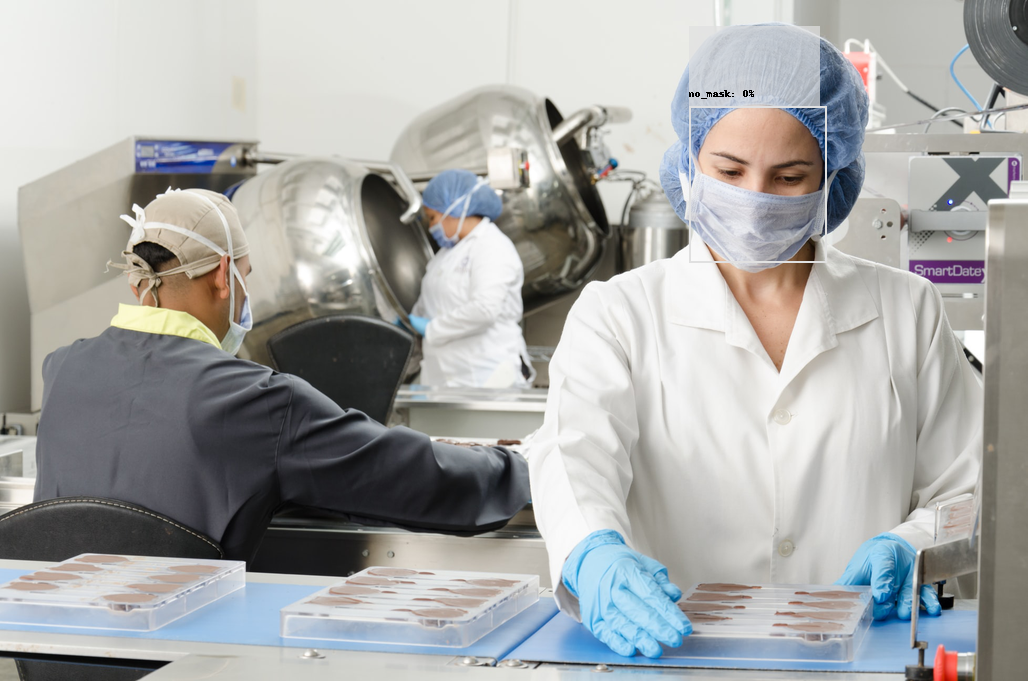

In [9]:
from utils import visualize_detection

visualize_detection(file_name, result["detections"])

_Photo by Getty Images_

### Delete the Endpoint
Having an endpoint running will incur some costs. Therefore as a clean-up job, we should delete the endpoint.

In [10]:
sess.delete_endpoint(predictor.endpoint)

### Generate Prediction using Batch Transform

#### Uploading input data to S3

In [11]:
input_data_folder = 'sample_data/demo_input'
s3_data_folder = 'ppe_mask_detection_model_batch_testing/input'

input_data_location = sess.upload_data(input_data_folder, key_prefix=s3_data_folder)
output_data_location = input_data_location.replace('input', 'output')

#### Starting a new Batch Transform Job

In [12]:
transformer = model.transformer(instance_count=1,
                               instance_type='ml.c4.2xlarge',
                               output_path=output_data_location,
                               strategy='SingleRecord',
                               assemble_with=None,
                               accept='image/jpeg')

Using already existing model: vitechlab-ppe-mask-detector-2020-05-22-08-51-49-256


In [ ]:
transformer.transform(input_data_location, 
    content_type='image/jpeg',
    compression_type=None,
    split_type=None,
    join_source=None)

transformer.wait()

#### Download and display the result file

In [14]:
output_file_name = 'image1.jpg.out'
dest_path = 'sample_data/demo_raw_output/' + output_file_name
s3_path = 'ppe_mask_detection_model_batch_testing/output/' + output_file_name

bucket = sess.boto_session.resource('s3').Bucket(sess.default_bucket())
bucket.download_file(s3_path, dest_path)

with open(dest_path, 'r') as file:
    print(file.read())

{"detections": [{"box_points": [388, 240, 459, 323], "classes": {"no_mask": 0.01940169744193554}}, {"box_points": [783, 168, 862, 249], "classes": {"no_mask": 0.4069998860359192}}, {"box_points": [284, 180, 349, 257], "classes": {"no_mask": 6.9776082038879395}}, {"box_points": [563, 263, 633, 341], "classes": {"no_mask": 0.06506367027759552}}, {"box_points": [103, 229, 160, 304], "classes": {"no_mask": 0.14078108966350555}}, {"box_points": [716, 248, 787, 319], "classes": {"no_mask": 0.013263734988868237}}, {"box_points": [196, 259, 251, 329], "classes": {"no_mask": 0.4641539752483368}}, {"box_points": [663, 228, 726, 296], "classes": {"no_mask": 0.2763673961162567}}, {"box_points": [481, 226, 538, 287], "classes": {"no_mask": 0.066068135201931}}]}
